In [1]:
#Imports
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression

In [2]:
df = pd.read_csv("NCAA Champion RawData.csv")
print(list(df.columns))

['Season', '#', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Bracket Region', 'Bracket Region/Season', 'sum coach mmt gp', 'sum coach sea coa', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AdjTempo Rk', 'AdjOE Rk', 'AdjDE Rk', 'AdjEM Rk', 'Top 6 AdjEM Rk', 'round make', 'champion share', 'make tournament', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's"

In [3]:
data_columns = ['sum coach mmt gp', 'sum coach sea coa', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AdjTempo Rk', 'AdjOE Rk', 'AdjDE Rk', 'AdjEM Rk', 
                'Top 6 AdjEM Rk','champion share','Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 
                'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs',
                'sum school L3Y cs', 'sum school L5Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school Finals apps', 
                'sum school F4 apps', 'sum school E8 apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 
                'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
                'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
                '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum mm tour games', 'sum cf tour games', 
                'sum cf reg games', 'sum career games', 'sum polls made', 'poll_Pre 1', 'poll_Week 2', 'poll_Week 3', 'poll_Week 4', 'poll_Week 5',
                'poll_Week 6', 'poll_Week 7', 'poll_Week 8', 'poll_Week 9', 'poll_Week 10', 'poll_Week 11', 'poll_Week 12', 'poll_Week 13', 'poll_Week 14',
               'poll_Week 15', 'poll_Week 16', 'poll_Week 17', 'poll_Week 18', 'poll_avg', 'top_12_week 6 ', 'top_8_trac_pre', 't6(adjem)_t8(trac_pre)_t12(wk6)',
                'sum school cs', 'historical_school_rating', 'trac_pre', 'trac_pre_2', 'team_rating_avg_custom', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom', 'trac_pre_rk']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [25]:
feature_to_rank = 'champion share'
df['champion share rk'] = df.groupby('Season')[feature_to_rank].rank(ascending=False)
df['champion share rk'] = df['champion share rk'].astype(int)

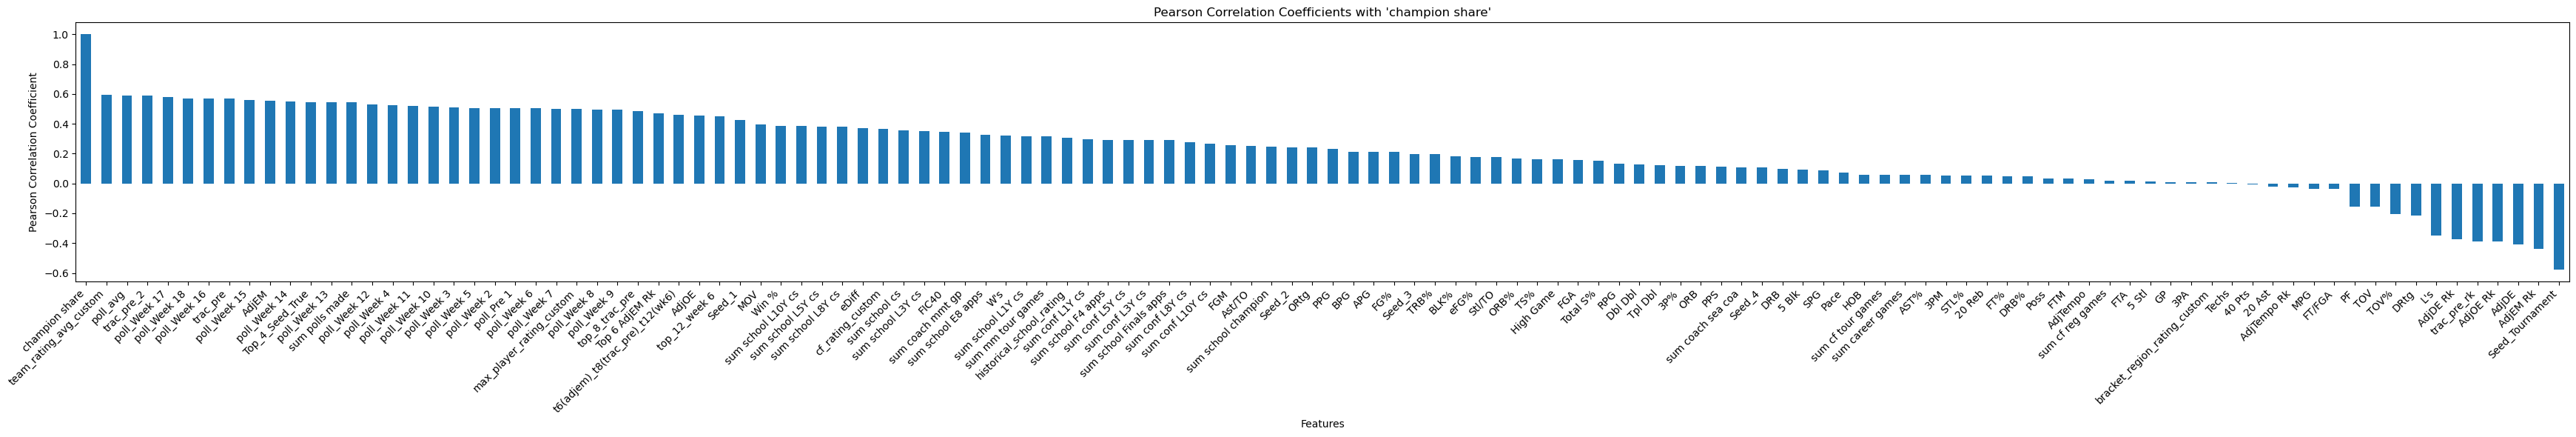

In [26]:

correlations = df[data_columns].corrwith(df['champion share'])


correlations = correlations.sort_values(ascending=False)


plt.figure(figsize=(35, 6))
correlations.plot(kind='bar')
plt.title("Pearson Correlation Coefficients with 'champion share'")
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
correlation_matrix = data.corr()

correlation_threshold = .9

columns_to_remove = set()
print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

Columns to be Removed:
AdjOE Rk (correlated with AdjOE): -0.92
AdjDE Rk (correlated with AdjDE): 0.93
AdjEM Rk (correlated with AdjEM): -0.95
sum conf L5Y cs (correlated with sum conf L3Y cs): 0.96
sum conf L8Y cs (correlated with sum conf L3Y cs): 0.91
sum school L8Y cs (correlated with sum school L5Y cs): 0.93
sum school L10Y cs (correlated with sum school L5Y cs): 0.90
historical_school_rating (correlated with sum school champion): 0.91
historical_school_rating (correlated with sum school Finals apps): 0.95
historical_school_rating (correlated with sum school F4 apps): 0.92
sum school cs (correlated with sum school E8 apps): 0.94
eFG% (correlated with TS%): 0.94
HOB (correlated with AST%): 0.97
TOV (correlated with TOV%): 0.90
SPG (correlated with STL%): 0.93
BPG (correlated with BLK%): 0.93
MOV (correlated with eDiff): 0.99
Win % (correlated with L's): -0.92
FGM (correlated with PPG): 0.91
3PA (correlated with 3PM): 0.92
FTA (correlated with FTM): 0.93
sum career games (correlated 

In [28]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'sum coach mmt gp', 'sum coach sea coa', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AdjTempo Rk', 'Top 6 AdjEM Rk', 'champion share', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs', 'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'W's', 'L's', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_week 6 

In [3]:
features = ['sum coach mmt gp', 'sum coach sea coa','AdjOE',
            'Top 6 AdjEM Rk',
            'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs',
            'sum school L3Y cs', 'sum school L5Y cs', 'sum school champion', 'sum school Finals apps', 
            'sum school F4 apps', 'sum school E8 apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%',
            'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 
            'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'Techs', 'Ast/TO',
            'Stl/TO', 'FT/FGA', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM','MOV', '3PA', 'SPG', 'BPG', 'TOV', 'FGM', 'sum school cs','historical_school_rating',
            'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 
            'sum cf reg games', 'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7',
            'poll_Week 10', 'poll_Week 13', 'top_12_week 6 ', 'top_8_trac_pre',
            't6(adjem)_t8(trac_pre)_t12(wk6)', 'team_rating_avg_custom',  
            'cf_rating_custom', 'bracket_region_rating_custom']

            
num_features = len(features)

print(f"Number of features: {num_features}")


Number of features: 80


In [4]:
all_features = ['sum coach mmt gp', 'sum coach sea coa', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AdjTempo Rk', 'AdjOE Rk', 'AdjDE Rk', 'AdjEM Rk', 
                'Top 6 AdjEM Rk','champion share','Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 
                'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs',
                'sum school L3Y cs', 'sum school L5Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school Finals apps', 
                'sum school F4 apps', 'sum school E8 apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 
                'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
                'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
                '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum mm tour games', 'sum cf tour games', 
                'sum cf reg games', 'sum career games', 'sum polls made', 'poll_Pre 1', 'poll_Week 2', 'poll_Week 3', 'poll_Week 4', 'poll_Week 5',
                'poll_Week 6', 'poll_Week 7', 'poll_Week 8', 'poll_Week 9', 'poll_Week 10', 'poll_Week 11', 'poll_Week 12', 'poll_Week 13', 'poll_Week 14',
               'poll_Week 15', 'poll_Week 16', 'poll_Week 17', 'poll_Week 18', 'poll_avg', 'top_12_week 6 ', 'top_8_trac_pre', 't6(adjem)_t8(trac_pre)_t12(wk6)',
                'sum school cs', 'historical_school_rating', 'trac_pre', 'trac_pre_2', 'team_rating_avg_custom', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom', 'trac_pre_rk']

total_all_features = len(all_features)

print(f"Total Number of features to use: {total_all_features}")

Total Number of features to use: 122


In [5]:
features_set = set(features)
all_features_set = set(all_features)

not_included_features = all_features_set - features_set

print("Features not included in the features list:")
for feature in not_included_features:
    print(feature)


Features not included in the features list:
L's
trac_pre_2
poll_Week 2
AdjTempo
poll_Week 3
poll_Week 6
sum career games
eFG%
Seed_2
sum school L10Y cs
poll_Week 8
trac_pre
sum conf L5Y cs
AdjEM Rk
trac_pre_rk
poll_Week 14
max_player_rating_custom
AdjDE Rk
Seed_Tournament
poll_Week 17
FTA
AdjTempo Rk
poll_Week 15
HOB
champion share
Seed_1
Win %
W's
poll_Week 5
poll_avg
poll_Week 9
AdjOE Rk
Seed_4
poll_Week 12
poll_Week 16
poll_Week 11
sum conf L8Y cs
AdjEM
Seed_3
poll_Week 18
sum school L8Y cs
AdjDE


In [ ]:
#parameter storage

Champion AP for Season 2019: 0.25 | Reciprocal: 4.0
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0
Champion AP for Season 2022: 0.25 | Reciprocal: 4.0
Champion AP for Season 2023: 0.33 | Reciprocal: 3.0

features = [ 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'sum conf L1Y cs', 
            'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs',
            'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 
            'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg',
            'MOV', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
            'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM',
            'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 
            'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16',
            'top_12_week 6 ', 'top_8_team_rating', 't6(adjem)_t8(tr)_t12(wk6)', 'team_rating_avg_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

rf = RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=100, random_state=15) 
rf.fit(train[features], train["champion share"])
            
num_features = len(features)

print(f"Number of features: {num_features}")


=============================================================================================================================================

Champion AP for Season 2019: 0.2 | Reciprocal: 5.0
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0
Champion AP for Season 2022: 0.25 | Reciprocal: 4.0
Champion AP for Season 2023: 0.5 | Reciprocal: 2.0


rf = RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=54, random_state=15) 
rf.fit(train[features], train["champion share"])


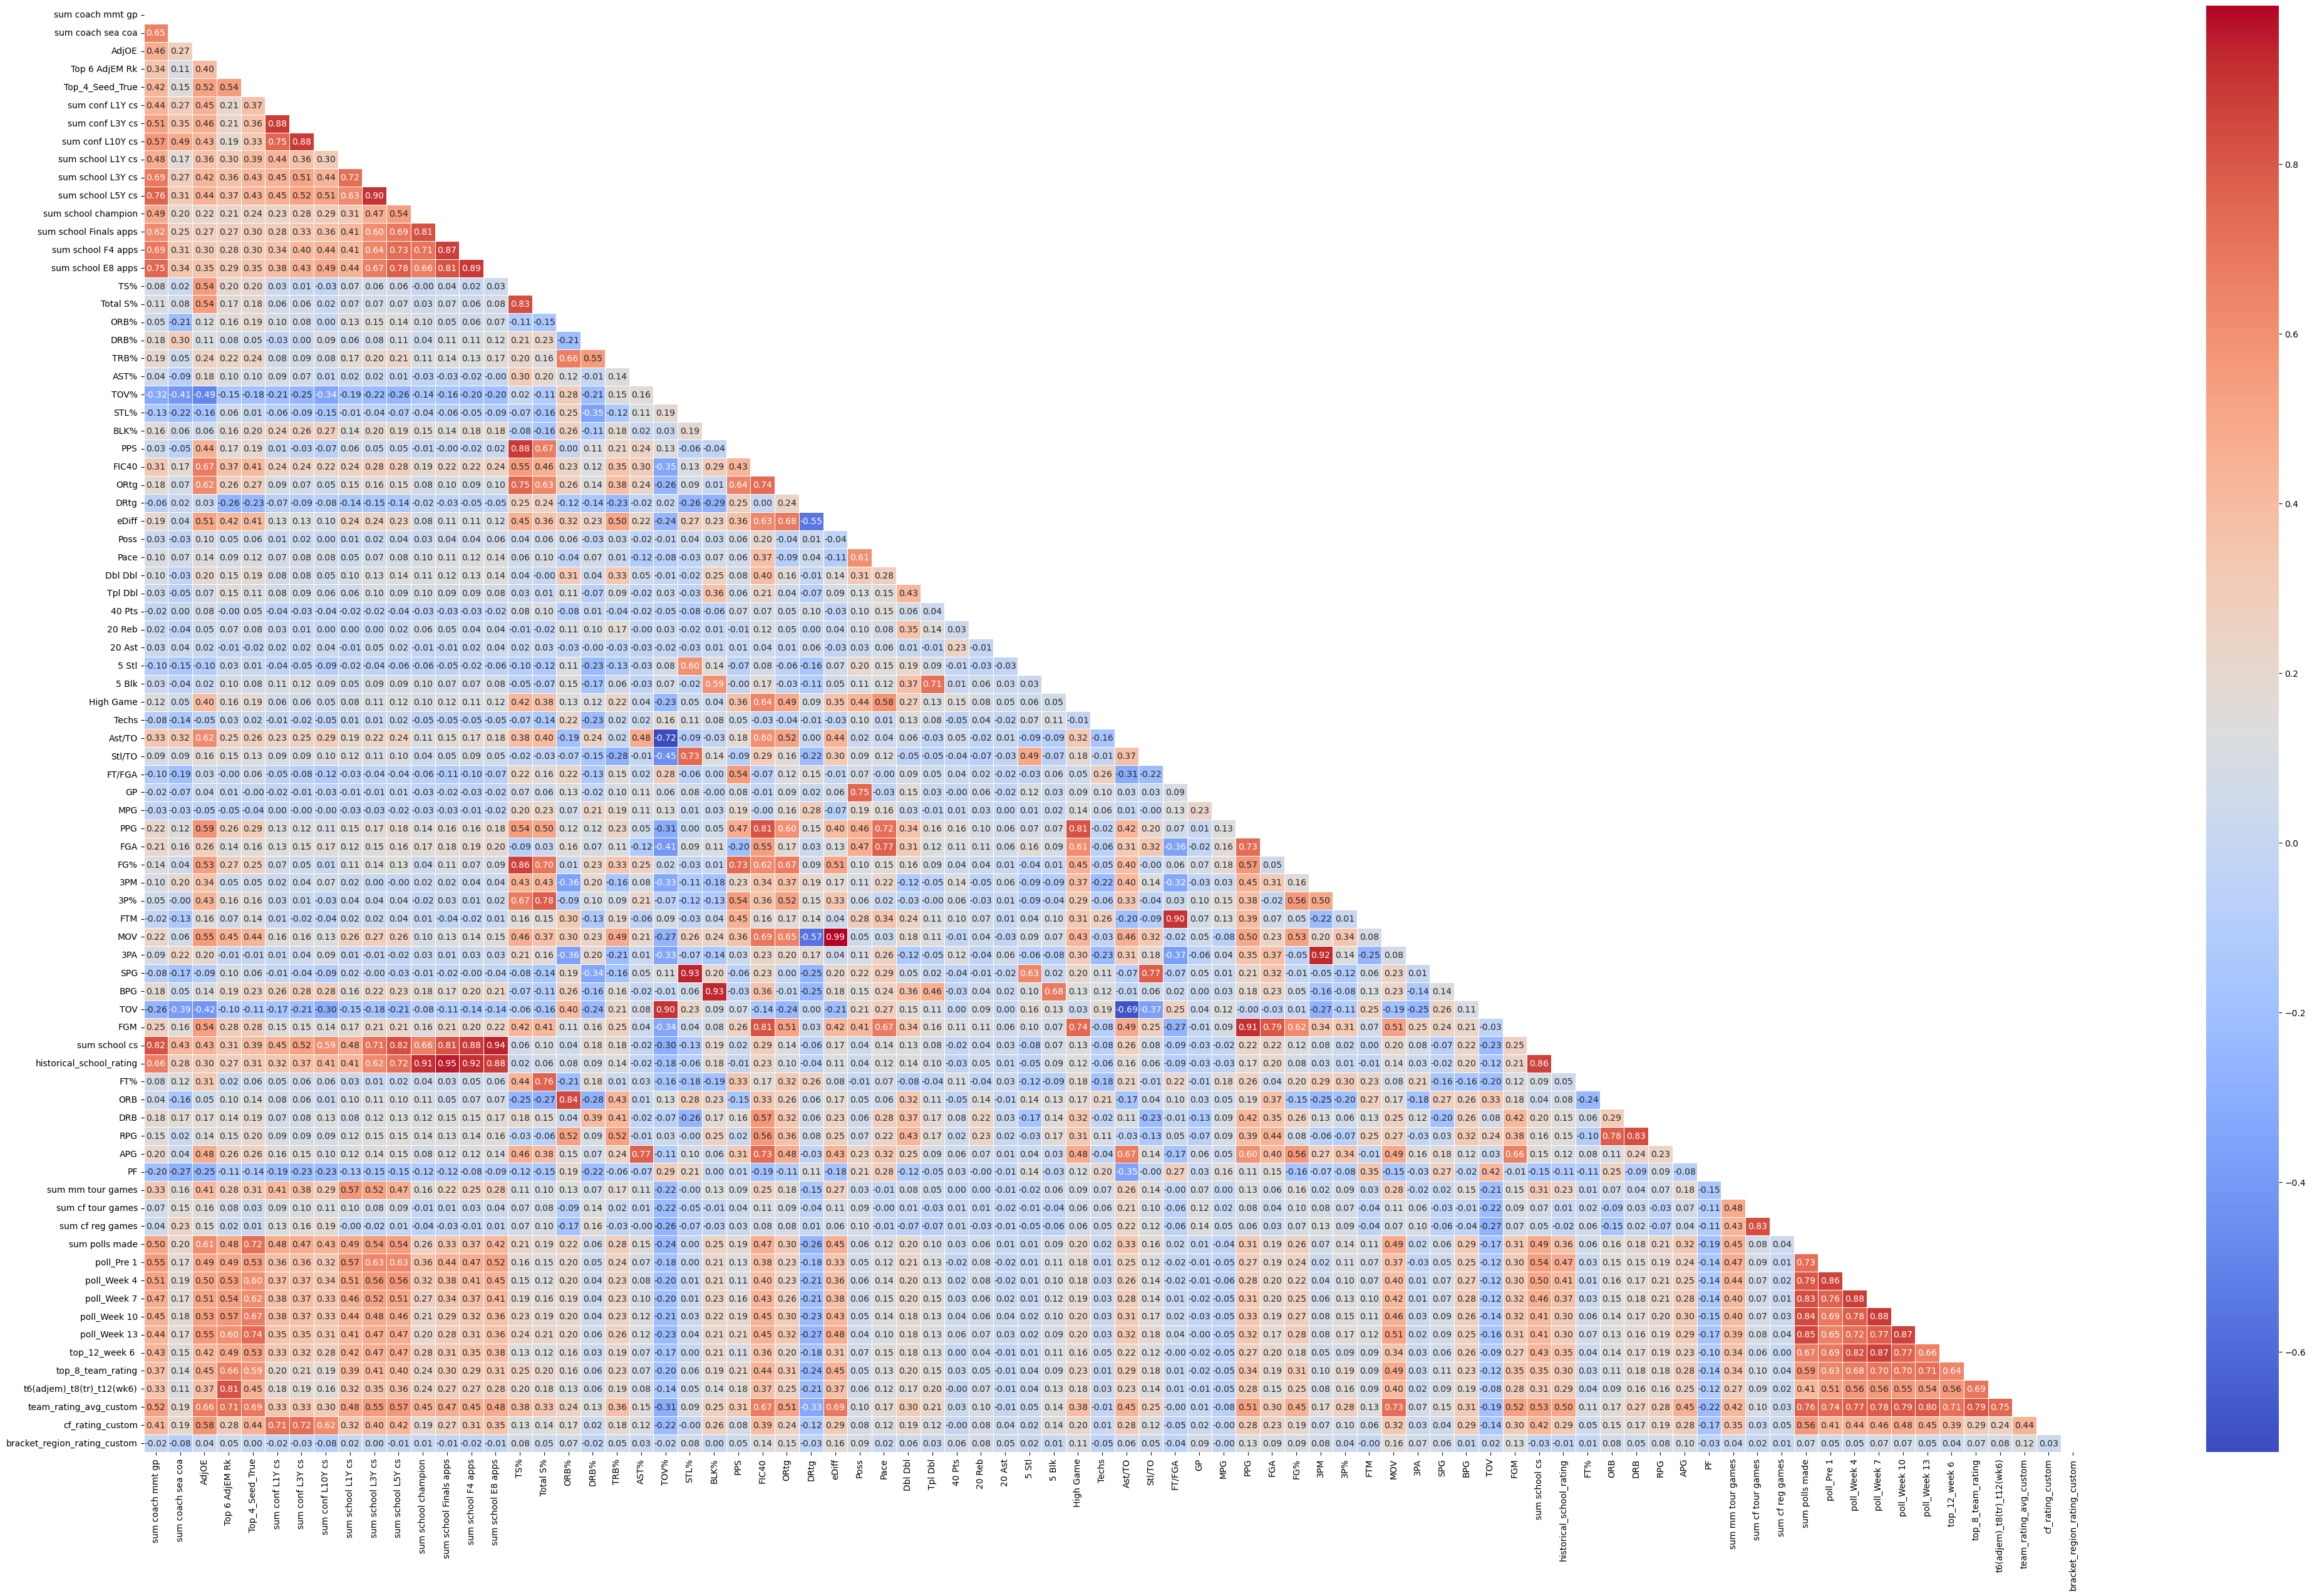

In [226]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(50, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

### Random Forest:

In [4]:
train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

rf = RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=100, random_state=15)
rf.fit(train[features], train["champion share"])


predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])


mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make tournament"] == True]


predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)


frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)


frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])


print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(10))

Error Metrics: 

PT MAE:  0.19411232629353534
PT MSE:  0.06579415258025477
PT RMSE:  0.2565037087066282
-----------------------------------------------------------------------------

Feature Importance: 

Top_4_Seed_True           0.222001
team_rating_avg_custom    0.168733
sum polls made            0.035903
AdjOE                     0.016737
PF                        0.015565
poll_Pre 1                0.015006
DRtg                      0.014423
DRB%                      0.013827
sum conf L10Y cs          0.013329
BLK%                      0.013224
Poss                      0.012492
MPG                       0.011985
BPG                       0.011935
FT/FGA                    0.011933
sum cf tour games         0.011772
FT%                       0.011762
FTM                       0.011686
TRB%                      0.010982
sum conf L3Y cs           0.010695
3P%                       0.010668
dtype: float64
-----------------------------------------------------------------------------

F

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


### RandomForest Champion Evaluation:

In [5]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x    Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2024  Purdue               0.0                    0.709313     1      2024               0.0                    0.709313               1

PT AP Champion:  1.0


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



all_predictions = []
aps = []

#backtest_seasons = [2021,2022,2023]
backtest_seasons = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(10)
    
    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2004: 1.0 | Reciprocal: 1.0
Champion AP for Season 2005: 1.0 | Reciprocal: 1.0
Champion AP for Season 2006: 0.2 | Reciprocal: 5.0
Champion AP for Season 2007: 0.2 | Reciprocal: 5.0
Champion AP for Season 2008: 1.0 | Reciprocal: 1.0
Champion AP for Season 2009: 0.5 | Reciprocal: 2.0
Champion AP for Season 2010: 0.25 | Reciprocal: 4.0
Champion AP for Season 2011: 0.08 | Reciprocal: 13.0
Champion AP for Season 2012: 1.0 | Reciprocal: 1.0
Champion AP for Season 2013: 0.14 | Reciprocal: 7.0
Champion AP for Season 2014: 0.05 | Reciprocal: 20.0
Champion AP for Season 2015: 0.2 | Reciprocal: 5.0
Champion AP for Season 2016: 0.17 | Reciprocal: 6.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 1.0 | Reciprocal: 1.0
Champion AP for Season 2019: 0.17 | Reciprocal: 6.0
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0
Champion AP for Season 2022: 0.25 | Reciprocal: 4.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0
Champion AP for Season

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root

### Random Forest Top 16 Teams Evaluation:

In [30]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(16) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(16) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                Team  champion share_x  Season_x  predicted champion share_x          Team/Season_x  Rank  champion share_y  Season_y  predicted champion share_y          Team/Season_y  Predicted Rank
0        Connecticut          1.000000      2023                    0.589520       Connecticut 2023     1          1.000000      2023                    0.589520       Connecticut 2023               1
1    San Diego State          0.833333      2023                    0.162920   San Diego State 2023     2          0.833333      2023                    0.162920   San Diego State 2023              28
2         Miami (FL)          0.666667      2023                    0.104120        Miami (FL) 2023     3          0.666667      2023                    0.104120        Miami (FL) 2023              43
3   Florida Atlantic          0.666667      2023                    0.150638  Florida Atlantic 2023     4          0.666667      2023                    0.150638  Flo

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


all_predictions = []
aps = []

backtest_seasons = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)


    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Top 16 AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)


for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(16)

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Top 16 AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Top 16 AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Top 16 AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Top 16 AP for Season 2005: 0.63 | Reciprocal: 1.58
Top 16 AP for Season 2006: 0.78 | Reciprocal: 1.28
Top 16 AP for Season 2007: 0.84 | Reciprocal: 1.19
Top 16 AP for Season 2008: 0.7 | Reciprocal: 1.43
Top 16 AP for Season 2009: 0.82 | Reciprocal: 1.22
Top 16 AP for Season 2010: 0.53 | Reciprocal: 1.89
Top 16 AP for Season 2011: 0.6 | Reciprocal: 1.67
Top 16 AP for Season 2012: 0.75 | Reciprocal: 1.33
Top 16 AP for Season 2013: 0.73 | Reciprocal: 1.38
Top 16 AP for Season 2014: 0.63 | Reciprocal: 1.59
Top 16 AP for Season 2015: 0.68 | Reciprocal: 1.48
Top 16 AP for Season 2016: 0.64 | Reciprocal: 1.56
Top 16 AP for Season 2017: 0.67 | Reciprocal: 1.49
Top 16 AP for Season 2018: 0.48 | Reciprocal: 2.09
Top 16 AP for Season 2019: 0.78 | Reciprocal: 1.28
Top 16 AP for Season 2021: 0.54 | Reciprocal: 1.86
Top 16 AP for Season 2022: 0.63 | Reciprocal: 1.59
Top 16 AP for Season 2023: 0.6 | Reciprocal: 1.67

Average Error Metrics Across All Seasons:
BT Average Top 16 AP: 0.67 | Reciprocal: 1

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root

In [12]:
combined_predictions.to_csv('L4S Preds.csv', index=False)

### Feature Evaluation:

Top Features:
['Top_4_Seed_True', 'team_rating_avg_custom', 'sum polls made', 'AdjOE', 'poll_Pre 1', 'sum conf L1Y cs', 'poll_Week 13', 'TOV%', 'DRB%', 'sum coach sea coa', 'MPG', 'BLK%', 'poll_Week 4', 'sum conf L10Y cs', 'sum school cs', 'BPG', '3PA', 'TOV', 'Poss', 'Stl/TO', 'FT/FGA', 'PF', 'sum cf reg games', 'TRB%', 'sum mm tour games', 'DRtg', 'ORB', 'Ast/TO', 'sum school L3Y cs', 'sum coach mmt gp', 'FT%', 'FTM', 'MOV', 't6(adjem)_t8(trac_pre)_t12(wk6)', 'sum conf L3Y cs', 'STL%', 'cf_rating_custom', 'Dbl Dbl', 'RPG', 'AST%', 'bracket_region_rating_custom', '3PM', 'sum cf tour games', 'DRB', 'sum school L1Y cs', 'ORB%', 'PPG', 'SPG', '3P%', 'Pace', 'FIC40', '5 Blk', 'eDiff', 'historical_school_rating', 'TS%', 'FG%', 'APG', 'FGA', 'Total S%', 'Techs', 'Top 6 AdjEM Rk', 'High Game', 'poll_Week 7', 'sum school L5Y cs', '5 Stl', 'FGM', 'poll_Week 10', 'sum school E8 apps', 'ORtg', 'sum school F4 apps', 'GP', 'Tpl Dbl', 'PPS', 'sum school Finals apps', '20 Reb', '40 Pts', 'top_12_wee

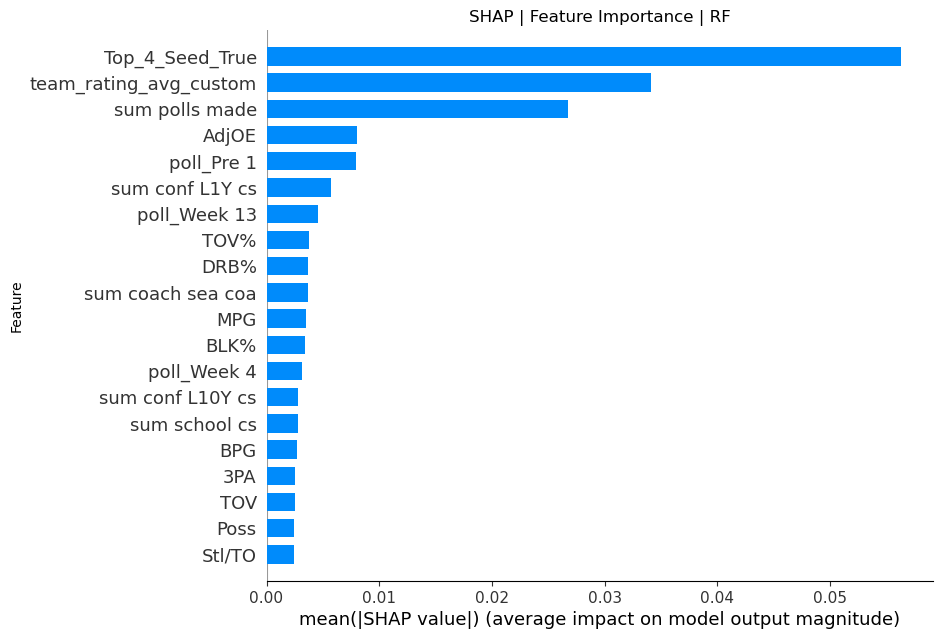

In [8]:
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

shap.summary_plot(shap_values, test[features], feature_names=features, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Feature Importance | RF')
plt.savefig("rf_shap_bar.png", bbox_inches='tight', pad_inches=0.1)

image = Image.open("rf_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_bar.png")

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1]

top_features_list = [features[index] for index in top_features]
print("Top Features:")
print(top_features_list)

plt.ylabel("Feature")
plt.show()

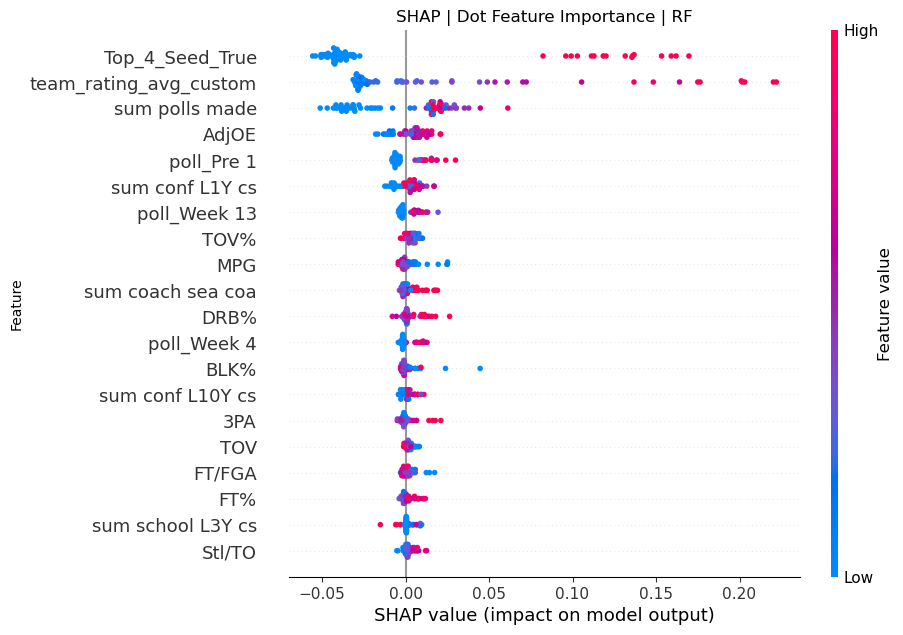

In [23]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | RF')

plt.savefig("rf_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_dot.png")

plt.ylabel("Feature")
plt.show()

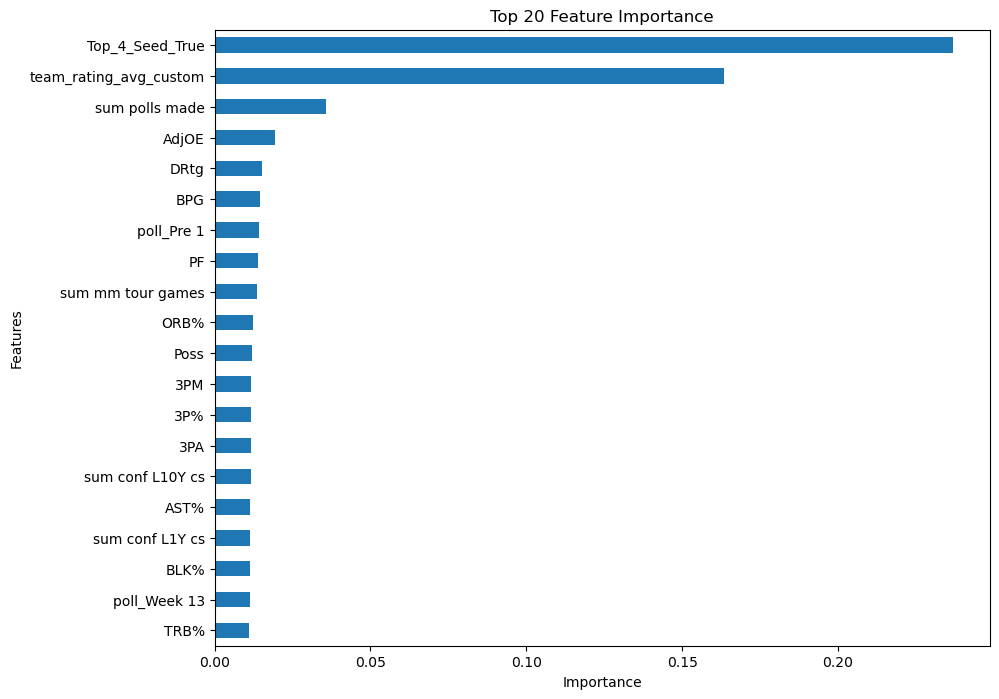

In [38]:
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index=f_list).sort_values(ascending=False)

top_features = f_importance.head(20)

plt.figure(figsize=(10, 8))
top_features.sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### Linear Model:

In [9]:
train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

reg = Ridge(alpha=.5)
reg.fit(train[features], train["champion share"])


predictions = reg.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])


mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


coefficients =reg.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
print("Top 10 absolute coefficients:")
for feature, coefficient in sorted_feature_coefficients[:10]:
    print(f"Feature: {feature}, Coefficient: {coefficient}")


frame_playoff = test[test["make tournament"] == True]


predictions = reg.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)


frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)


frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])


print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(10))

Error Metrics: 

PT MAE:  0.172778366180277
PT MSE:  0.05436368068943677
PT RMSE:  0.233160203914469
-----------------------------------------------------------------------------

Top 10 absolute coefficients:
Feature: AdjOE, Coefficient: 0.24665597856951738
Feature: sum school L3Y cs, Coefficient: -0.16390240041791096
Feature: t6(adjem)_t8(trac_pre)_t12(wk6), Coefficient: 0.14727079886460434
Feature: SPG, Coefficient: 0.11601844964609172
Feature: Top_4_Seed_True, Coefficient: 0.10984100570806164
Feature: sum mm tour games, Coefficient: 0.10115760556966938
Feature: poll_Week 7, Coefficient: -0.0971991992220375
Feature: MPG, Coefficient: 0.0955275244024502
Feature: ORB, Coefficient: 0.09523656528917834
Feature: FTM, Coefficient: -0.09392821084799219
Full Results (Playoff Teams Only):

    Season            Team  champion share  predicted champion share
3     2024           Uconn             0.0                  0.761713
12    2024         Houston             0.0                  0.58832

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


In [10]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x   Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2024  Uconn               0.0                    0.761713     1      2024               0.0                    0.761713               1

PT AP Champion:  1.0


In [11]:

all_predictions = []
aps = []

#backtest_seasons = [2021,2022,2023]
backtest_seasons = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    reg.fit(train[features], train['champion share'])
    predictions = reg.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\n Top 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2004: 1.0 | Reciprocal: 1.0
Champion AP for Season 2005: 0.14 | Reciprocal: 7.0
Champion AP for Season 2006: 0.33 | Reciprocal: 3.0
Champion AP for Season 2007: 0.2 | Reciprocal: 5.0
Champion AP for Season 2008: 1.0 | Reciprocal: 1.0
Champion AP for Season 2009: 0.33 | Reciprocal: 3.0
Champion AP for Season 2010: 0.33 | Reciprocal: 3.0
Champion AP for Season 2011: 0.03 | Reciprocal: 31.0
Champion AP for Season 2012: 1.0 | Reciprocal: 1.0
Champion AP for Season 2013: 1.0 | Reciprocal: 1.0
Champion AP for Season 2014: 0.04 | Reciprocal: 23.0
Champion AP for Season 2015: 0.17 | Reciprocal: 6.0
Champion AP for Season 2016: 0.25 | Reciprocal: 4.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 0.5 | Reciprocal: 2.0
Champion AP for Season 2019: 0.25 | Reciprocal: 4.0
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0
Champion AP for Season 2022: 1.0 | Reciprocal: 1.0
Champion AP for Season 2023: 0.5 | Reciprocal: 2.0
Champion AP for Seas

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root

In [37]:
import xgboost as xgb

train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

xgb = xgb.XGBRegressor(learning_rate=0.12, max_depth=4, n_estimators=9, random_state=15)
xgb.fit(train[features], train["champion share"])


predictions = xgb.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])


mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")



frame_playoff = test[test["make tournament"] == True]


predictions = xgb.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)


frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)


frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])


print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(10))

Error Metrics: 

PT MAE:  0.29838272590528836
PT MSE:  0.10540906916704064
PT RMSE:  0.32466762876369526
-----------------------------------------------------------------------------

Full Results (Playoff Teams Only):

    Season            Team  champion share  predicted champion share
7     2024         Arizona             0.0                  0.678506
3     2024           Uconn             0.0                  0.638309
16    2024            Duke             0.0                  0.617715
14    2024          Purdue             0.0                  0.611462
17    2024  North Carolina             0.0                  0.582172
33    2024        Kentucky             0.0                  0.499458
12    2024         Houston             0.0                  0.490145
46    2024          Kansas             0.0                  0.476568
10    2024       Tennessee             0.0                  0.458125
44    2024          Baylor             0.0                  0.455891


'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


In [52]:

all_predictions = []
aps = []

#backtest_seasons = [2021,2022,2023]
backtest_seasons = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    xgb.fit(train[features], train['champion share'])
    predictions = xgb.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\n Top 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2005: 1.0 | Reciprocal: 1.0
Champion AP for Season 2006: 0.08 | Reciprocal: 13.0
Champion AP for Season 2007: 0.2 | Reciprocal: 5.0
Champion AP for Season 2008: 0.2 | Reciprocal: 5.0
Champion AP for Season 2009: 1.0 | Reciprocal: 1.0
Champion AP for Season 2010: 0.25 | Reciprocal: 4.0
Champion AP for Season 2011: 0.07 | Reciprocal: 15.0
Champion AP for Season 2012: 0.25 | Reciprocal: 4.0
Champion AP for Season 2013: 0.17 | Reciprocal: 6.0
Champion AP for Season 2014: 0.04 | Reciprocal: 27.0
Champion AP for Season 2015: 0.25 | Reciprocal: 4.0
Champion AP for Season 2016: 0.12 | Reciprocal: 8.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 0.33 | Reciprocal: 3.0
Champion AP for Season 2019: 0.2 | Reciprocal: 5.0
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0

 Top 5 Predicted Teams for Season 2005:
                Team  predict

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root